In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
n_pretraining = 50
n_trials = 50
learning_rate = 0.15

# Assignment 2: Prediction Learning

## Conditioning

Simulate data for each of the following conditioning paradigms:

- Blocking
- Inhibitory conditioning
- Overshadowing
- Secondary conditioning
- Explaining away

To do this, generate arrays which correspond to the sequences of presented stimuli and the sequences of presented rewards (ignore time within a trial for this, each entry is one trial). Also generate an idealised sequence of expectations of rewards of the animal (the expectation occurs after the presentation of the CS but before the potential presentation of a reward).

Now use the Rescorla-Wagner rule to learn these expectations, based on the stimulus and reward vectors you generated.

For which paradigms do your learned expectations qualitatively agree with your idealised predictions? For the non-matching paradigms, speculate why the Rescorla-Wagner rule failed to produce the correct expectations.

### Blocking

The **blocking paradigm** is a phenomenon where prior learning interferes with new learning about a stimulus when that stimulus is paired with an already familiar cue.

Phases:
(1) Pre-training: a stimulus A, $s_A$, is associated with the reward, $r$.
(2) Training: $s_A$ is presented alongside a new stimulus B, $s_B$. Both cues continue to predict the reward, $r$.
(3) Result: conditioned stimulus A, $s_A$, continues to predict the reward, while conditioned stimulus B, $s_B$, is not associated with the reward. The previously learned stimulus A essentially “blocks” stimulus B from forming a significant association with the reward.

In [3]:
# Define stimuli
stimulusA = np.ones(n_pretraining + n_trials + 1).astype(bool)
stimulusB = np.concatenate([
    np.zeros(n_pretraining),  # do not present stimulus B during pre-training
    np.ones(n_trials + 1)
]).astype(bool)

# Define rewards
rewards = np.ones(n_pretraining + n_trials + 1).astype(bool)

# Expected rewards (theoretical)
expectationA = np.concatenate([
    1 - np.exp(-learning_rate * np.arange(n_pretraining)),
    np.ones(n_trials + 1)
])
expectationB = np.zeros(n_pretraining + n_trials + 1)

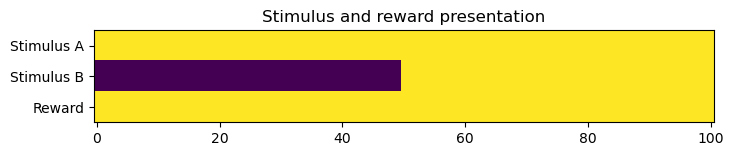

In [4]:
_, ax = plt.subplots(figsize = (8, 5))

plt.imshow([stimulusA, stimulusB, rewards], aspect = "equal")

ax.set_aspect(5)
ax.set_yticks(np.arange(0, 3), labels = ["Stimulus A", "Stimulus B", "Reward"])
plt.title("Stimulus and reward presentation")

plt.show()

In [5]:
# stimuli
u = np.array([stimulusA, stimulusB])
alpha = learning_rate
r = rewards

# predicted rewards
v = np.zeros(shape = (n_pretraining + n_trials + 1, 2))
# weights
w = np.zeros(shape = (n_pretraining + n_trials + 1, 2))

for i in np.arange(1, u.shape[1]):
    v_exp = np.sum(v[i - 1])
    delta_w = alpha * (r[i - 1] - v_exp) * u[:, i - 1]
    w[i] = w[i - 1] + delta_w
    v[i] = w[i] * u[:, i]

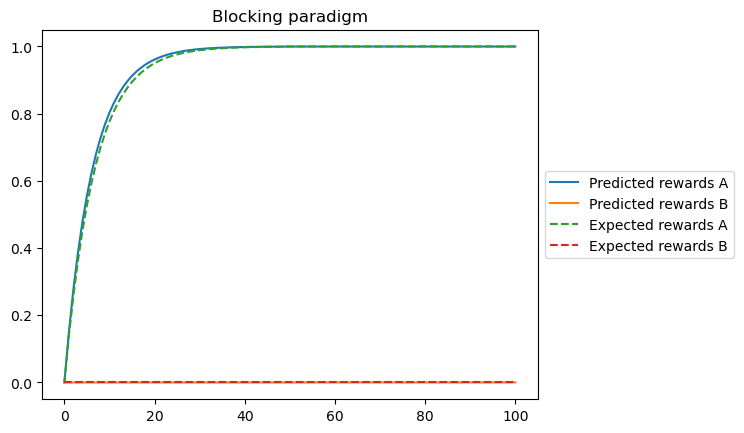

In [6]:
plt.plot(w[:, 0], label = "Predicted rewards A")
plt.plot(w[:, 1], label = "Predicted rewards B")

plt.plot(expectationA, label = "Expected rewards A", linestyle = "dashed")
plt.plot(expectationB, label = "Expected rewards B", linestyle = "dashed")

plt.legend(loc = "center left", bbox_to_anchor = (1, 0.5))
plt.title("Blocking paradigm")

plt.show()

TODO: include interpretation of the results